# Insurance Price Prediction - Modeling

## Imports

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
from sklearn.preprocessing import StandardScaler

## Load Dataset

In [14]:
file_path = r"C:\Users\fabia\OneDrive - National University of Singapore\Documents\SDS Insurance Price Predictor\insurance.csv"
# Load data into dataframe
df = pd.read_csv(file_path)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 1338 rows, 7 columns


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Feature Engineering

In [15]:
# Binary encoding: smoker = 1, non-smoker = 0
smoker_map = {'yes': 1, 'no': 0}
df['smoker_encoded'] = df['smoker'].map(smoker_map)

# Binary encoding: male = 1, female = 0
sex_map = {'male': 1, 'female': 0}
df['sex_encoded'] = df['sex'].map(sex_map)

# One-hot encoding for region
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True, dtype=int)
df = pd.concat([df, region_dummies], axis=1)

# Create interaction term: BMI × Smoker
df['bmi_smoker_interaction'] = df['bmi'] * df['smoker_encoded']

# check processed dataframe
df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_encoded,sex_encoded,region_northwest,region_southeast,region_southwest,bmi_smoker_interaction
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,1,27.9
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,1,0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,1,0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,1,0,0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,1,0,0,0.0


# Baseline Model: Linear Regression
Build baseline linear regression model including all features AND the interaction term bmi x smoker as it was discussed to be important earlier. Use this as performance benchmark.

Cross-validated R² scores: [0.862 0.792 0.881 0.818 0.833]
Mean CV R²: 0.837 (+/- 0.031)
Mean CV RMSE: $4,850 (+/- 392)
Mean Charges (All Data): $13,270
CV RMSE / Mean Charges: 36.55%


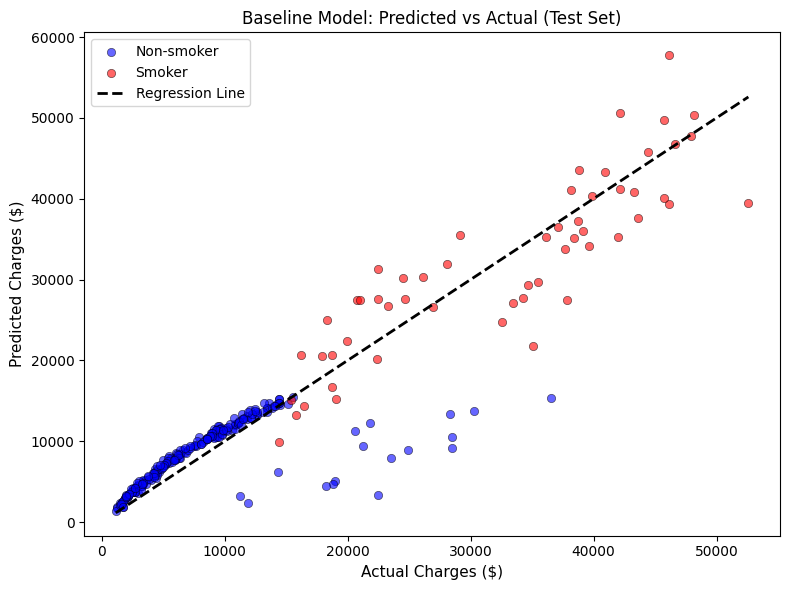

In [16]:
# Select features and target
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded', 
                'region_northwest', 'region_southeast', 'region_southwest', 
                'bmi_smoker_interaction']
X = df[feature_cols]
y = df['charges']

# Train model
model_baseline = LinearRegression()

# Split: 80% train, 20% test (used for visualisation later)
    # Stratify by smoker status to maintain distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker_encoded'])
model_baseline.fit(X_train, y_train)
y_pred = model_baseline.predict(X_test)

# Calculate CV metrics
cv_r2_scores = cross_val_score(model_baseline, X, y, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(model_baseline, X, y, cv=5, scoring='neg_root_mean_squared_error')
mean_cv_rmse = -cv_rmse_scores.mean()
mean_charges = y.mean()

# output results
print(f"Cross-validated R² scores: {np.round(cv_r2_scores, 3)}")
print(f"Mean CV R²: {cv_r2_scores.mean():.3f} (+/- {cv_r2_scores.std():.3f})")
print(f"Mean CV RMSE: ${mean_cv_rmse:,.0f} (+/- {cv_rmse_scores.std():.0f})")
print(f"Mean Charges (All Data): ${mean_charges:,.0f}")
print(f"CV RMSE / Mean Charges: {mean_cv_rmse / mean_charges:.2%}")

# visualise actual vs predicted charges, colored by smoker status
smoker_test = X_test['smoker_encoded']

plt.figure(figsize=(8, 6))
plt.scatter(y_test[smoker_test == 0], y_pred[smoker_test == 0], alpha=0.6, edgecolors='k', linewidth=0.5, label='Non-smoker', color='blue')
plt.scatter(y_test[smoker_test == 1], y_pred[smoker_test == 1], alpha=0.6, edgecolors='k', linewidth=0.5, label='Smoker', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Regression Line')
plt.xlabel('Actual Charges ($)', fontsize=11)
plt.ylabel('Predicted Charges ($)', fontsize=11)
plt.title('Baseline Model: Predicted vs Actual (Test Set)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis of Metrics (Baseline Model)**   
Mean CV $R^2$: Proportion of variance in 'charges' that the model explains. Higher is better.  
Mean CV RMSE: The average magnitude of prediction errors, in dollars. Lower is better.  
CV RMSE / Mean Charges: The average prediction error as a percentage of the average charge; a measure of relative error. Lower is better.

The high R² (0.837) indicates the model captures most cost variation, but the RMSE of $4,850 represents substantial absolute error - approximately 36.55% of mean charges ($13,270). This suggests the model performs well at explaining overall patterns but struggles with precise individual predictions. We will visualise predicted vs actual values to better assess prediction quality across the charges range.

**Analysis of Predicted vs Actual Chart**  
The model predicts accurately for charges <$15k, evidenced by tight clustering along the diagonal. For actual charges >$15k, prediction accuracy deteriorates for both groups. The model systematically underpredicts high-charges cases: smokers (red points) show increasing deviation from regression line as actual charges rise. High-charges non-smokers (blue points >$15k) are also substantially underpredicted, with the model estimating ~$8k-$13k when actual charges reach $15k-$35k.  

**Important Note**  
Cross-validation (5-fold) was used to provide more robust performance estimates than a single train-test split. This method splits the data into 5 subsets, trains on 4 and tests on 1, rotating through all combinations. The reported metrics represent averages across all folds, reducing sensitivity to how the data is randomly split and providing a more reliable assessment of model generalisation.

**Summary:** The baseline model struggles to predict high charges for both smokers and non-smokers.

**Next Step**  
We will next perform backward elimination to reduce model complexity. This method iteratively removes the least significant predictors (those with p-values > 0.05) until only statistically significant features remain.

### Backward Elimination

In [17]:
# feature columns and target variable
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded', 
                'region_northwest', 'region_southeast', 'region_southwest', 
                'bmi_smoker_interaction']
X = df[feature_cols]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker_encoded'])

# START: Backward Elimination Process
    # start with all feature columns
current_features = feature_cols.copy()
significance_level = 0.05

while len(current_features) > 0:
    # add intercept term
    X_train_ols = sm.add_constant(X_train[current_features])
    
    # fit OLS (Ordinary Least Squares) model
    model_stats = sm.OLS(y_train, X_train_ols).fit()
    
    # get p-values and remove the 'const'
    pvalues = model_stats.pvalues.drop('const')
    
    # find feature with the highest p-value
    max_p_value = pvalues.max()
    
    if max_p_value > significance_level:
        # remove high p-value feature
        feature_to_remove = pvalues.idxmax()
        current_features.remove(feature_to_remove)
        print(f"Removed '{feature_to_remove}' (p-value: {max_p_value:.3f})")
    else:
        break

# print model summary with remaining features
X_train_final = sm.add_constant(X_train[current_features])
final_model_stats = sm.OLS(y_train, X_train_final).fit()
print(final_model_stats.summary())

Removed 'bmi' (p-value: 0.921)
Removed 'region_northwest' (p-value: 0.165)
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     776.1
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:07:26   Log-Likelihood:                -10608.
No. Observations:                1070   AIC:                         2.123e+04
Df Residuals:                    1062   BIC:                         2.127e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

### Reduced Model: Removed bmi and region_northwest

In [18]:
# create x matrix with final selected features
X_final = df[current_features] 
y_final = df['charges']

# select and train new model
model_final = LinearRegression()

# cross validate new model for model evaluation
cv_r2_scores = cross_val_score(model_final, X_final, y_final, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(model_final, X_final, y_final, cv=5, scoring='neg_root_mean_squared_error')
mean_cv_rmse = -cv_rmse_scores.mean()
mean_charges = y_final.mean()

# 4. Print the new (and likely very similar) scores
print(f"Cross-validated R² scores: {np.round(cv_r2_scores, 3)}")
print(f"Mean CV R²: {cv_r2_scores.mean():.3f} (+/- {cv_r2_scores.std():.3f})")
print(f"Mean CV RMSE: ${mean_cv_rmse:,.0f} (+/- {cv_rmse_scores.std():.0f})")
print(f"CV RMSE / Mean Charges: {mean_cv_rmse / mean_charges:.2%}")


Cross-validated R² scores: [0.864 0.791 0.88  0.818 0.832]
Mean CV R²: 0.837 (+/- 0.032)
Mean CV RMSE: $4,848 (+/- 392)
CV RMSE / Mean Charges: 36.53%


**Analysis**  
Upon removing `bmi` and `region_northwest`, the mean cross-validated $R^2$ of the reduced model did not show a significant degradation in performance. This indicates these variables have negligible predictive power, and we can adopt the more parsimonious model without sacrificing explanatory accuracy.

## Modification 1: Inclusion of BMI Threshold Interaction Term
We will create obesity dummy variable `obese` for individuals with bmi >= 30.  

Rationale: Medical literature defines BMI ≥ 30 as the clinical threshold for obesity, which is associated with substantially higher health risks and medical costs. Testing whether a threshold effect (obese vs non-obese) captures cost variations better than treating BMI as a continuous variable, particularly for smokers where the EDA showed BMI strongly predicts charges (r = 0.806).

### Enhanced Model: REPLACED `bmi_smoker_interaction` with `obese_smoker`

Cross-validated R² scores: [0.889 0.792 0.892 0.851 0.872]
Mean CV R²: 0.859 (+/- 0.036)
Mean CV RMSE: $4,487 (+/- 428)
CV RMSE / Mean Charges: 33.81%


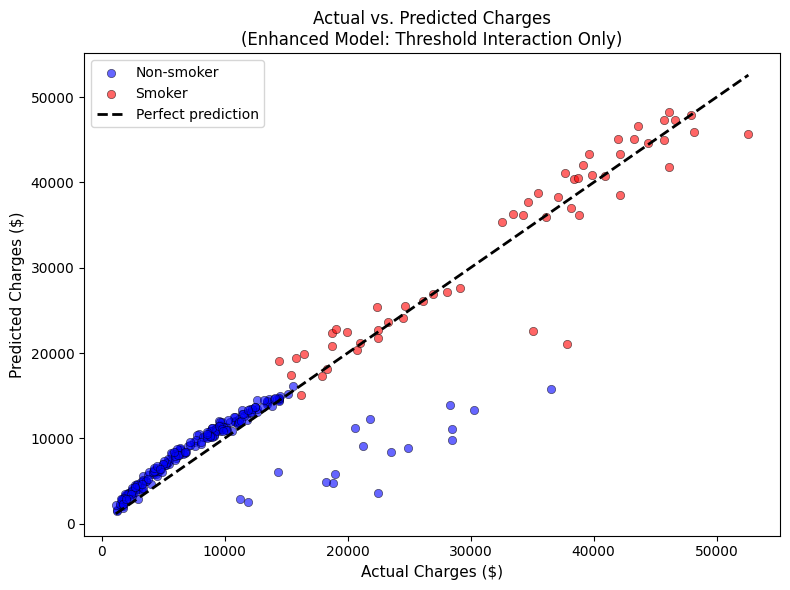

In [19]:
# create dummy variable and interaction term
df['obese'] = (df['bmi'] >= 30).astype(int)
df['obese_smoker'] = df['obese'] * df['smoker_encoded']

# include threshold interaction term 'obese_smoker', exclude continuous interaction term 'bmi_smoker_interaction'
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded', 
                'region_southeast', 'region_southwest', 'obese_smoker']

# select features and target
X = df[feature_cols]
y = df['charges'] 

# select model
model = LinearRegression()

# split and train for plotting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker_encoded'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate CV metrics
cv_r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
mean_cv_rmse = -cv_rmse_scores.mean()
mean_charges = y.mean()

# 4. Output results
print(f"Cross-validated R² scores: {np.round(cv_r2_scores, 3)}")
print(f"Mean CV R²: {cv_r2_scores.mean():.3f} (+/- {cv_r2_scores.std():.3f})")
print(f"Mean CV RMSE: ${mean_cv_rmse:,.0f} (+/- {cv_rmse_scores.std():.0f})")
print(f"CV RMSE / Mean Charges: {mean_cv_rmse / mean_charges:.2%}")

# plot predicted vs actual charges, colored by smoker status
model_title = "Enhanced Model: Threshold Interaction Only"
smoker_test = X_test['smoker_encoded']
plt.figure(figsize=(8, 6))
plt.scatter(y_test[smoker_test == 0], y_pred[smoker_test == 0], alpha=0.6, edgecolors='k', linewidth=0.5, label='Non-smoker', color='blue')
plt.scatter(y_test[smoker_test == 1], y_pred[smoker_test == 1], alpha=0.6, edgecolors='k', linewidth=0.5, label='Smoker', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Charges ($)', fontsize=11)
plt.ylabel('Predicted Charges ($)', fontsize=11)
plt.title(f"Actual vs. Predicted Charges\n({model_title})", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis of replacing `bmi_smoker_interaction` with `obese_smoker`**  
Binarising the interaction term by replacing the continuous bmi_smoker_interaction with a threshold-based obese_smoker feature enhanced the models predictive power.This modification yielded a meaningful increase in the mean cross-validated $R^2$ (0.837 to 0.859) and a corresponding reduction in the relative error (CV RMSE / Mean Charges) from 36.53% to 33.81%. This suggests the impact of smoking on charges is better captured by a discrete obesity threshold than by a continuous linear BMI relationship.

Observing the Predicted against Actual chart, The new model is much better at predicting high-cost smokers (charges > $15,000). The predictions (red points) are now clustered more tightly around the regression line signifying smaller residuals. Unfortunately, the model still has the same major flaw: it systematically underpredicts high-cost non-smokers as chown by the blue points that are consistently below the line for actual charges over $15,000.

### Enhanced Model: Includes BOTH `bmi_smoker_interaction` and `obese_smoker`

Cross-validated R² scores: [0.892 0.8   0.899 0.856 0.87 ]
Mean CV R²: 0.863 (+/- 0.035)
Mean CV RMSE: $4,422 (+/- 428)
CV RMSE / Mean Charges: 33.32%


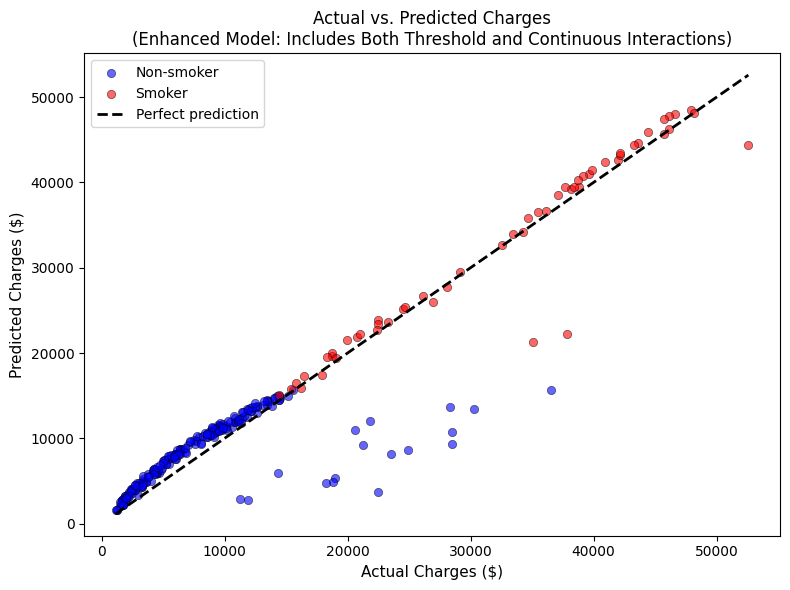

In [20]:
# create dummy variable and interaction term
df['obese'] = (df['bmi'] >= 30).astype(int)
df['obese_smoker'] = df['obese'] * df['smoker_encoded']

# include threshold interaction term 'obese_smoker', exclude continuous interaction term 'bmi_smoker_interaction'
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded', 
                'region_southeast', 'region_southwest', 'obese_smoker', 'bmi_smoker_interaction']

# select features and target
X = df[feature_cols]
y = df['charges'] 

# select model
model = LinearRegression()

# split and train for plotting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker_encoded'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate CV metrics
cv_r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
mean_cv_rmse = -cv_rmse_scores.mean()
mean_charges = y.mean()

# 4. Output results
print(f"Cross-validated R² scores: {np.round(cv_r2_scores, 3)}")
print(f"Mean CV R²: {cv_r2_scores.mean():.3f} (+/- {cv_r2_scores.std():.3f})")
print(f"Mean CV RMSE: ${mean_cv_rmse:,.0f} (+/- {cv_rmse_scores.std():.0f})")
print(f"CV RMSE / Mean Charges: {mean_cv_rmse / mean_charges:.2%}")

# plot predicted vs actual charges, colored by smoker status
model_title = "Enhanced Model: Includes Both Threshold and Continuous Interactions"
smoker_test = X_test['smoker_encoded']
plt.figure(figsize=(8, 6))
plt.scatter(y_test[smoker_test == 0], y_pred[smoker_test == 0], alpha=0.6, edgecolors='k', linewidth=0.5, label='Non-smoker', color='blue')
plt.scatter(y_test[smoker_test == 1], y_pred[smoker_test == 1], alpha=0.6, edgecolors='k', linewidth=0.5, label='Smoker', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Charges ($)', fontsize=11)
plt.ylabel('Predicted Charges ($)', fontsize=11)
plt.title(f"Actual vs. Predicted Charges\n({model_title})", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis of including both `bmi_smoker_interaction` and `obese_smoker`**  
Including both interaction terms yields marginal metric improvement over the threshold-only model, with R² increasing from 0.859 to 0.863 and RMSE decreasing by $65. Importantly, comparing the charts reveals Option B produces significantly tighter clustering of smoker predictions (red points) along the diagonal indicating more accurate and consistent predictions for this group. The combination of improved metrics and visibly better prediction accuracy for smokers makes Option B (threshold + continuous) the superior model, as the added complexity is justified by meaningful performance gains in the critical smoker segment.

However, we would like to investigate what points the model is exactly underpredicting. We will next create an interactive plot to uncover properties of these data points that sit far from the regression line.

In [21]:
# create dataframe for plotting
plot_df = X_test.copy()
plot_df['Actual Charges'] = y_test
plot_df['Predicted Charges'] = y_pred

# Map smoker_encoded to a readable string for the legend
plot_df['Smoker Status'] = plot_df['smoker_encoded'].map({0: 'Non-smoker', 1: 'Smoker'})

# create interactive scatter plot with Plotly
fig = px.scatter(
    plot_df,
    x='Actual Charges',
    y='Predicted Charges',
    color='Smoker Status',  # Colors points by smoker status
    color_discrete_map={'Non-smoker': 'blue', 'Smoker': 'red'},
    hover_data=['age', 'bmi', 'Actual Charges', 'Predicted Charges'], # Data to show on hover
    title=f"Actual vs. Predicted Charges"
)

# add perfect regression line (y=x)
fig.add_shape(
    type='line',
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max(),
    line=dict(color='Black', dash='dash')
)

fig.update_layout(xaxis_title='Actual Charges ($)', yaxis_title='Predicted Charges ($)', width=800, height=600)
fig.show()

**Analysis**  
Closer examination reveals that underpredicted non-smokers with actual charges above $20k appear to share obesity (BMI ≥ 30) and advanced age. We test whether these characteristics genuinely distinguish high-cost non-smokers by comparing their mean age and obesity rates to all non-smokers.

In [22]:
# Compare high-cost non-smokers to all non-smokers
high_cost_nonsmokers = df[(df['smoker_encoded']==0) & (df['charges']>20000)]
all_nonsmokers = df[df['smoker_encoded']==0]

print(f"High-cost: mean age={high_cost_nonsmokers['age'].mean():.1f}, % obese={high_cost_nonsmokers['obese'].mean():.1%}")
print(f"All non-smokers: mean age={all_nonsmokers['age'].mean():.1f}, % obese={all_nonsmokers['obese'].mean():.1%}")

High-cost: mean age=45.1, % obese=52.5%
All non-smokers: mean age=39.4, % obese=52.8%


High-cost non-smokers average 45.1 years (vs 39.4 overall) with 52.5% obese (vs 52.8% overall), indicating obesity rates are identical and age differences are modest. This confirms high costs stem from unmeasured factors rather than age-obesity interactions, so no additional interaction terms are warranted.

### Interpretation of Model

In [23]:
# Fit model with statsmodels for detailed statistics
X_train_const = sm.add_constant(X_train)
model_stats = sm.OLS(y_train, X_train_const).fit()

# 1. Full summary with coefficients, p-values, confidence intervals
print(model_stats.summary())
print("\n" + "="*70)

# 2. Feature importance based on standardized coefficients
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_const = sm.add_constant(X_train_scaled)

model_scaled = sm.OLS(y_train, X_train_scaled_const).fit()

# Create importance dataframe (use index from params directly)
importance_df = pd.DataFrame({
    'Feature': model_stats.params.index[1:],
    'Coefficient': model_stats.params.values[1:],
    'Std_Coefficient': model_scaled.params.values[1:],
    'p-value': model_stats.pvalues.values[1:],
    '|Std_Coef|': abs(model_scaled.params.values[1:])
}).sort_values('|Std_Coef|', ascending=False)

print("\nFeature Importance (sorted by absolute standardized coefficient):")
print(importance_df.to_string(index=False))
print("\n" + "="*70)

# 3. Interpretation of key coefficients
print("\nKey Coefficient Interpretations (original scale):")
for _, row in importance_df.head(5).iterrows():
    print(f"{row['Feature']:25s}: ${row['Coefficient']:>10,.2f} (p={row['p-value']:.4f})")
    
print(f"\nIntercept: ${model_stats.params['const']:,.2f}")

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     744.6
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:07:26   Log-Likelihood:                -10512.
No. Observations:                1070   AIC:                         2.104e+04
Df Residuals:                    1060   BIC:                         2.109e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1441

---

### SUMMARY: LINEAR REGRESSION MODEL

**About Model**
* Best version of the model: Inclusion of  `bmi_smoker_interaction` and `obese_smoker`  
* Features Included: `age`, '`bmi`, `children`, `smoker_encoded`, `sex_encoded`, `region_southeast`, `region_southwest`, `obese_smoker`, `bmi_smoker_interaction`

**Assessment Metrics**  
* Mean CV R²: 0.863 (+/- 0.035) 
* Mean CV RMSE: $4,422 (+/- 428)
* CV RMSE / Mean Charges: 33.32%

**Strenghths**  
The model is consistent in predicting charges for
1. smokers 
2. low-risk (low-charges) non-smoker group 
with very minimal systematic overprediction

**Weakness**  
Model systematically underpredicts high-charges (high-risk) non-smoker groups. The existing features is insufficient and more risk-identifying features such as chronic conditions, injuries, surgeries and medications are needed to better identify and predict charges for this group.

---

# Advanced Model: Random Forest Regressor 

Mean CV R²: 0.837 (+/- 0.034)
Mean CV RMSE: $4,853
CV RMSE / Mean Charges: 36.57%
            Feature  Importance
3    smoker_encoded    0.618710
1               bmi    0.216567
0               age    0.132577
2          children    0.017159
4       sex_encoded    0.005575
5  region_southeast    0.005015
6  region_southwest    0.004397


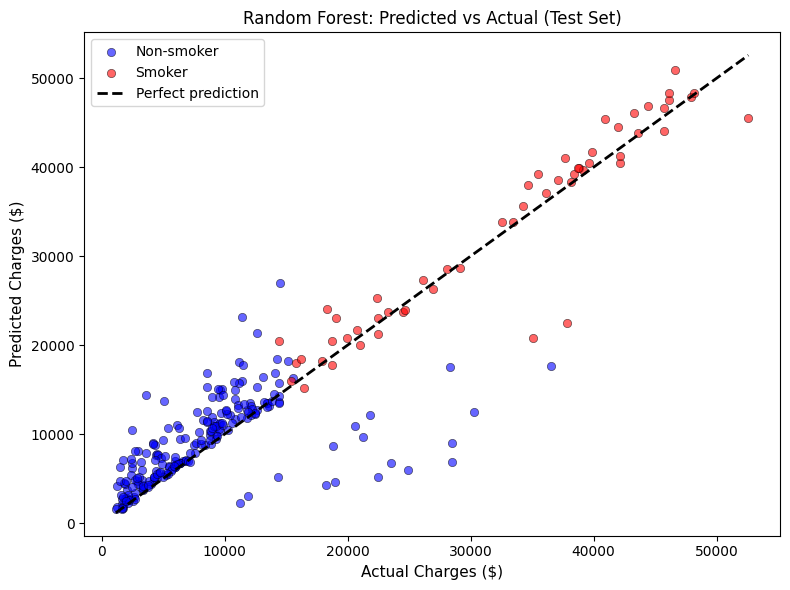

In [24]:
# Use simple features: let Random Forest find interactions
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded', 
                'region_southeast', 'region_southwest']
X = df[feature_cols]
y = df['charges']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['smoker_encoded'])

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Metrics
# CV for robust metrics
cv_r2 = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
cv_rmse = cross_val_score(rf_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Mean CV R²: {cv_r2.mean():.3f} (+/- {cv_r2.std():.3f})")
print(f"Mean CV RMSE: ${-cv_rmse.mean():,.0f}")
print(f"CV RMSE / Mean Charges: {-cv_rmse.mean() / mean_charges:.2%}")

# Feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df)

# Plot predicted vs actual
smoker_test = X_test['smoker_encoded']
plt.figure(figsize=(8, 6))
plt.scatter(y_test[smoker_test == 0], y_pred_rf[smoker_test == 0], alpha=0.6, edgecolors='k', linewidth=0.5, label='Non-smoker', color='blue')
plt.scatter(y_test[smoker_test == 1], y_pred_rf[smoker_test == 1], alpha=0.6, edgecolors='k', linewidth=0.5, label='Smoker', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Charges ($)', fontsize=11)
plt.ylabel('Predicted Charges ($)', fontsize=11)
plt.title('Random Forest: Predicted vs Actual (Test Set)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Analysis**  
The Random Forest model is weaker compared to the enhanced linear regression model (R² = 0.837 vs 0.863, RMSE = $4,853 vs $4,422), indicating no significant improvement in overall predictive accuracy. Feature importance analysis confirms smoking status as the dominant cost driver, contributing 61.9% of predictive power, followed by BMI (21.7%) and age (13.3%). Demographic factors (children, sex, region) collectively contribute less than 3%, validating the EDA findings that health-related variables dominate insurance cost predictions.  

However, the predicted vs actual plot reveals Random Forest exhibits greater prediction variability than linear regression. Both smokers (red) and non-smokers (blue) show increased scatter around the perfect prediction line, particularly in the $10k-20k range where linear regression achieved tight clustering. Most critically, the model perpetuates systematic underprediction of high-cost non-smokers (blue points above $15k consistently fall below the diagonal), suggesting the missing information about what drives extreme costs for non-smokers cannot be recovered even with advanced non-linear methods. The comparable performance to linear regression indicates the available features have reached their predictive limit for this dataset.
